In [1]:
]activate .

In [4]:
using Distributed
using Plots
using LaTeXStrings
using Statistics
using StatsBase
using Random

#addprocs(8)
include("fluo_cont_meas_sim.jl")
include("likelihood.jl")
include("likelihood_strong.jl")
include("likelihood_strong_internal.jl")
include("likelihood_strong_everystep.jl")
include("fisher_cont_meas.jl")

parallel_fluo_continuous_measurement_het_classic_initial0 (generic function with 1 method)

In [15]:
# Experimental parameters
T1 = 15.0
TD = 5.0
Trabi = 2.
Tphi = 17.9

NTrajectories = 500

# Parameter dictionary to be passed to the functions
params = Dict( :Tfinal    => 20., # Final time
               :dt        => 0.1, # duration of infinitesimal time
               :Gamma1    => 1. / T1,   # Gamma fluoresence
               :GammaD    => 1. / TD,  # Gamma dephasing controllable
               :GammaPhi  => 1. / Tphi,  # Gamma dephasing not controllable
               :etavalF   => 0.14, # efficiency fluoresence heterodyne
               :etavalD   => 0.34, # efficiency dephasing homodyne
               :omegaTrue => 2 * pi / Trabi, # True value of omega
               :omegaMin  => 2., # minimum value of omega
               :omegaMax  => 4., # maximum value of omega
               :threshold => 0.375,
               :Nomega    => 500); # Resolution in omega for the Bayesian estimation

We now check that the estimation works with the simulated experiment

In [16]:
@time simData = parallel_fluo_continuous_measurement_het_simulation(NTrajectories; params...) 
@time simRes = Likelihood_strong(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 1, params...);

  0.054401 seconds (205.68 k allocations: 36.124 MiB, 4.42% gc time)
  6.658600 seconds (51.84 M allocations: 6.213 GiB, 12.16% gc time)


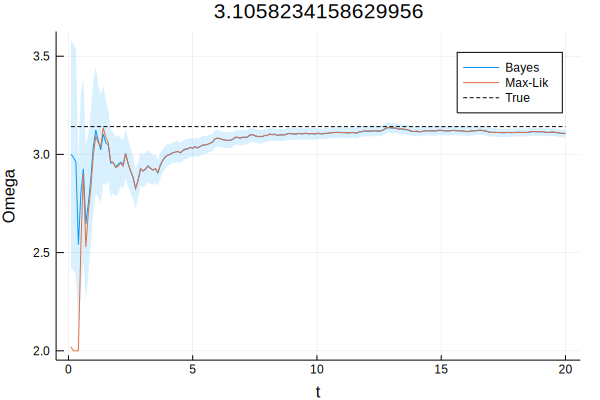

In [17]:
let res = simRes
    plot(res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes")
    xlabel!("t")
    ylabel!("Omega")
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash, color=:black, label="True")
    title!(string(res.omegaEst[end]))
end

In [19]:
include("likelihood_strong.jl")
@time simRes_internal = Likelihood_strong_internal(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 10, params...);

 51.205669 seconds (105.32 M allocations: 10.151 GiB, 3.90% gc time)


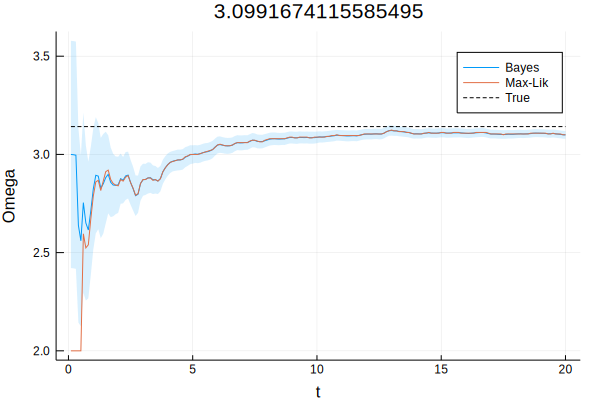

In [20]:
let res = simRes_internal
    plot(res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes")
    xlabel!("t")
    ylabel!("Omega")
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash, color=:black, label="True")
    title!(string(res.omegaEst[end]))
end

In [22]:
include("likelihood_strong_everystep.jl")
@time simRes_internal_every = Likelihood_strong_everystep(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 10, params...);

633.278084 seconds (9.13 G allocations: 467.123 GiB, 18.54% gc time)


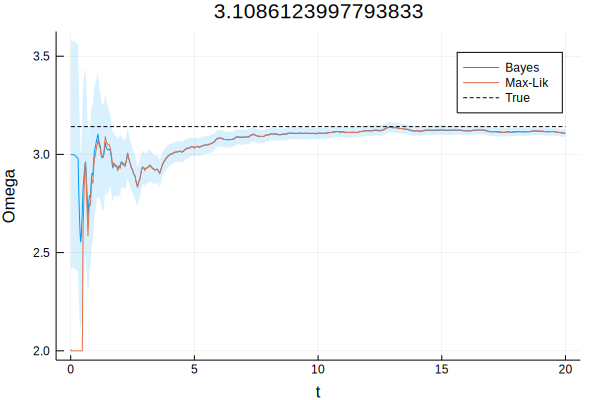

In [23]:
let res = simRes_internal_every
    plot(res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes")
    xlabel!("t")
    ylabel!("Omega")
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash, color=:black, label="True")
    title!(string(res.omegaEst[end]))
end

## Let's compare the Fisher information with our Bayesian variance

In [9]:
params_unconditional = copy(params)
params_unconditional[:etavalF] = 0.
params_unconditional[:etavalD] = 0.

#(tFisher, FisherAvgUncOmega15, QFisherAvgUncOmega15, FisherMAvgUncOmega15, QFisherEffUNCOmega15, FisherMEffUNCOmega15)
@time fisherUncResult = parallel_fluo_continuous_measurement_het_classic_initial0(10; Ntime=1000, params_unconditional...)
@time fisherResult = parallel_fluo_continuous_measurement_het_classic_initial0(5000; Ntime=1000, params...);

  3.256917 seconds (8.56 M allocations: 449.396 MiB, 6.61% gc time)
 59.053133 seconds (477.33 M allocations: 41.879 GiB, 11.77% gc time)


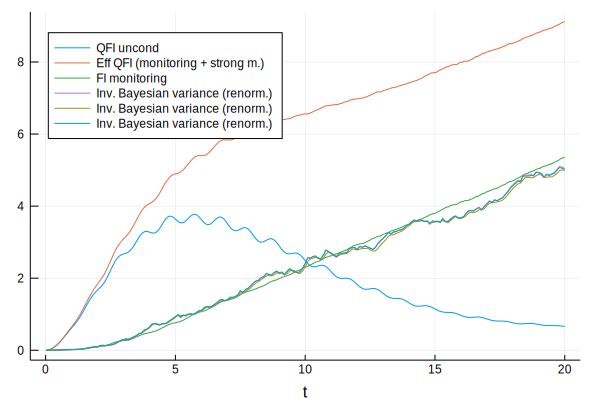

In [26]:
plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t, fisherResult.FisherAvg, label="FI monitoring")
plot!(simRes.t, simRes.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
plot!(simRes_internal.t, simRes_internal.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
plot!(simRes_internal_every.t, simRes_internal_every.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
xlabel!("t")

In [28]:
length(simRes_internal_every.t)

2000

## Other $\Omega$s

  0.010568 seconds (41.67 k allocations: 7.254 MiB)
  2.466459 seconds (20.49 M allocations: 1.996 GiB, 18.04% gc time)


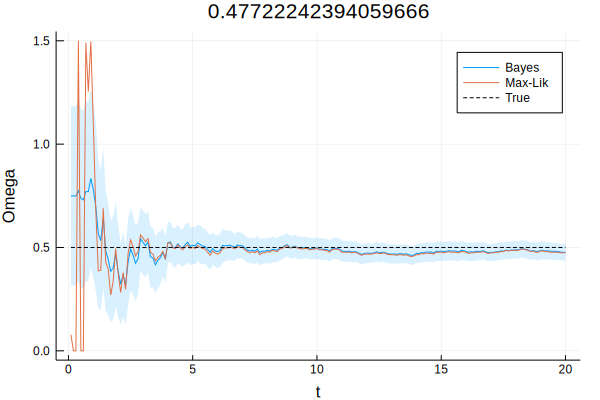

In [86]:
params[:omegaTrue] = .5
params[:omegaMin] = max(0, params[:omegaTrue] - 1)
params[:omegaMax] = params[:omegaTrue] + 1
@time simData = parallel_fluo_continuous_measurement_het_simulation(100; params...) 
@time simRes = Likelihood_strong(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 1, params...);

plot( simRes.t, simRes.omegaEst, ribbon=(simRes.sigmaBayes, simRes.sigmaBayes), fillalpha=0.15, label="Bayes")
xlabel!("t")
ylabel!("Omega")
plot!(simRes.t, simRes.omegaMaxLik, label="Max-Lik")
plot!(simRes.t, fill(params[:omegaTrue], size(simRes.t)), style=:dash, color=:black, label="True")
title!(string(simRes.omegaEst[end]))

In [90]:
function vsomega(omega, Ntrajectories, initialparams)
    params = copy(initialparams)
    params[:omegaTrue] = omega
    params[:omegaMin] = max(0, params[:omegaTrue] - 1)
    params[:omegaMax] = params[:omegaTrue] + 1
    simData = parallel_fluo_continuous_measurement_het_simulation(Ntrajectories; params...) 
    simRes = Likelihood_strong(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; params...);
    return simRes.omegaEst[end], simRes.sigmaBayes[end]
end



6-element Array{Tuple{Float64,Float64},1}:
 (0.48090938359389357, 0.0369102905434801) 
 (0.9553795729577654, 0.049017558879643874)
 (1.4404709856496742, 0.04552296553427718) 
 (1.999450041636865, 0.04746748478393397)  
 (2.4928457852935226, 0.04478942031847416) 
 (2.942020197388558, 0.03799212827515998)  

In [106]:
omegas = .25:.25:3
res = map(o -> vsomega(o, 100, params), omegas)

12-element Array{Tuple{Float64,Float64},1}:
 (0.3257611146144419, 0.03711837377507276) 
 (0.5526573538329544, 0.04226300984268288) 
 (0.8120391784569319, 0.055567508491524004)
 (1.0364992717980321, 0.06045816676810752) 
 (1.2283058569016347, 0.03793333669644459) 
 (1.4853320623418533, 0.037696421113548303)
 (1.765838206002324, 0.04332815995638043)  
 (1.965342861329028, 0.04763006054704427)  
 (2.202372015193769, 0.03976380751648822)  
 (2.416952528466885, 0.05104485017373432)  
 (2.774768137267594, 0.04526727160548601)  
 (2.9437052709443083, 0.049632836958552216)

In [109]:
omegas2 = .125 .+ (.25:.25:3)
res2 = map(o -> vsomega(o, 200, params), omegas2)

12-element Array{Tuple{Float64,Float64},1}:
 (0.4175250354993882, 0.031728480524457835)
 (0.5806839585880842, 0.031028253559461372)
 (0.8675158766671528, 0.0340005455259151)  
 (1.0811297342816568, 0.0267020696497903)  
 (1.3832555209743158, 0.028887754298644677)
 (1.6320258435198172, 0.034716746180626805)
 (1.8570708501764817, 0.03207282958107493) 
 (2.129294069120002, 0.04088528840437337)  
 (2.351452531767956, 0.032486242756282264) 
 (2.572591806558275, 0.02760888936116531)  
 (2.8726949489381473, 0.030162057784516565)
 (3.103921605422241, 0.0335933189747851)   

In [119]:
omegas3 = + (.5:.5:3)
res3 = map(o -> vsomega(o, 500, params), omegas3)

6-element Array{Tuple{Float64,Float64},1}:
 (0.507960155100093, 0.01813881624087434)  
 (0.9875847971646733, 0.021932254534704744)
 (1.4725515321523996, 0.018827118003077407)
 (1.9907974649296774, 0.01962307957878463) 
 (2.460241722820655, 0.019731839369371073) 
 (2.957669628615622, 0.019553817735962417) 

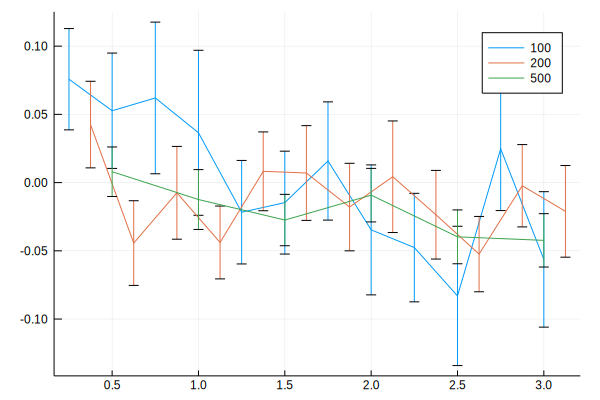

In [121]:
processed = collect.(collect(zip(res...)))
processed2 = collect.(collect(zip(res2...)))
processed3 = collect.(collect(zip(res3...)))
#plot(omegas, omegas ./ omegas)
plot(omegas, (processed[1] .- omegas), yerror=processed[2], label="100")
plot!(omegas2, (processed2[1] .- omegas2), yerror=processed2[2], label="200")
plot!(omegas3, (processed3[1] .- omegas3), yerror=processed3[2],label="500")

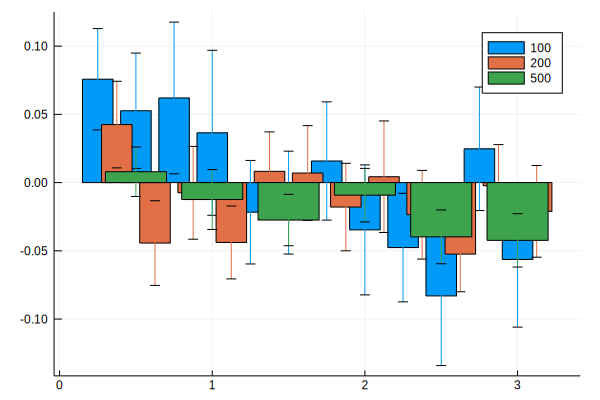

In [124]:
plot(omegas, (processed[1] .- omegas), yerror=processed[2], linetype=:bar, label="100")
plot!(omegas2, (processed2[1] .- omegas2), yerror=processed2[2], linetype=:bar, label="200")
plot!(omegas3, (processed3[1] .- omegas3), yerror=processed3[2], linetype=:bar, label="500")